Import


In [2]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision
import numpy as np

from utils.train import train,validate
import torch
import torch.nn as nn
import torch.utils as utils
from tqdm import tqdm

from utils.early_stopping import EarlyStopping
from timeit import default_timer as timer
import os


import pandas as pd
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
from torch.optim import  AdamW
from torch.optim import lr_scheduler

from utils.dataset import FaceDataset
from losses.hard_mine_triplet_loss import TripletLoss


from torchvision.transforms import transforms
from facenet_pytorch import InceptionResnetV1

from utils.cp import compute_metrics as cp
import sys



/media/data/public/facenet/ethics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def build_gallery(
    loader: DataLoader, model: nn.Module, device: torch.device, verbose: bool = False
):
    """
    Returns:
        gallery: a numpy array of shape (len(dataset), len(embedding))
                 storing the embeddings
        targets: a numpy array of shape (len(dataset), 1)
                 storing the labels
    """
    gallery = []
    targets = []
    model.eval()
   
    with torch.no_grad():
        if verbose:
            print("building gallery ...")
        for images, labels in tqdm(loader):
            # triplet datasets
            if isinstance(images, list):
                images = images[0].to(device)
                labels = labels[0]
            else:
                images = images.to(device)
            embeddings = model(images)
            gallery.extend(embeddings.to("cpu").numpy())
            targets.extend(labels)
    
    return np.asarray(gallery), np.asarray(targets)

# Part 1: Dataset Inspection

In [4]:

train_df=df=pd.read_csv("/media/data/public/facenet/FaceRecognition/original_dataset.csv", index_col= 'Unnamed: 0')
train_df.sort_values("SUBJECT_ID")
train_df.sort_values("TEMPLATE_ID")

test_df =pd.read_csv("/media/data/public/facenet/FaceRecognition/filtered.csv", index_col= 'Unnamed: 0')
test_df.sort_values("SUBJECT_ID")
test_df.sort_values("TEMPLATE_ID")

train_df

,TEMPLATE_ID,SUBJECT_ID,AGE,SKIN_COLOUR,GENDER,HEAD_POSE,SOURCE,GLASSES,BOUNDING_BOX_SIZE,PATH
0,91763,5,2,0,0,1,1,0,0,/media/data/public/facenet/datasets/FFR/test/d...
1,77952,5,2,0,0,0,1,0,1,/media/data/public/facenet/datasets/FFR/test/d...
2,66772,5,2,0,0,0,1,0,1,/media/data/public/facenet/datasets/FFR/test/d...
3,10882,5,2,0,0,0,1,0,1,/media/data/public/facenet/datasets/FFR/test/d...
4,82276,5,2,0,0,1,0,0,1,/media/data/public/facenet/datasets/FFR/test/d...
...,...,...,...,...,...,...,...,...,...,...
35586,41785,32624,1,1,0,0,0,0,1,/media/data/public/facenet/datasets/FFR/test/d...
35587,126494,32624,1,1,0,0,0,0,1,/media/data/public/facenet/datasets/FFR/test/d...
35588,9028,32624,1,1,0,0,0,0,1,/media/data/public/facenet/datasets/FFR/test/d...
35589,46520,32624,1,1,0,0,0,0,1,/media/data/public/facenet/datasets/FFR/test/d...


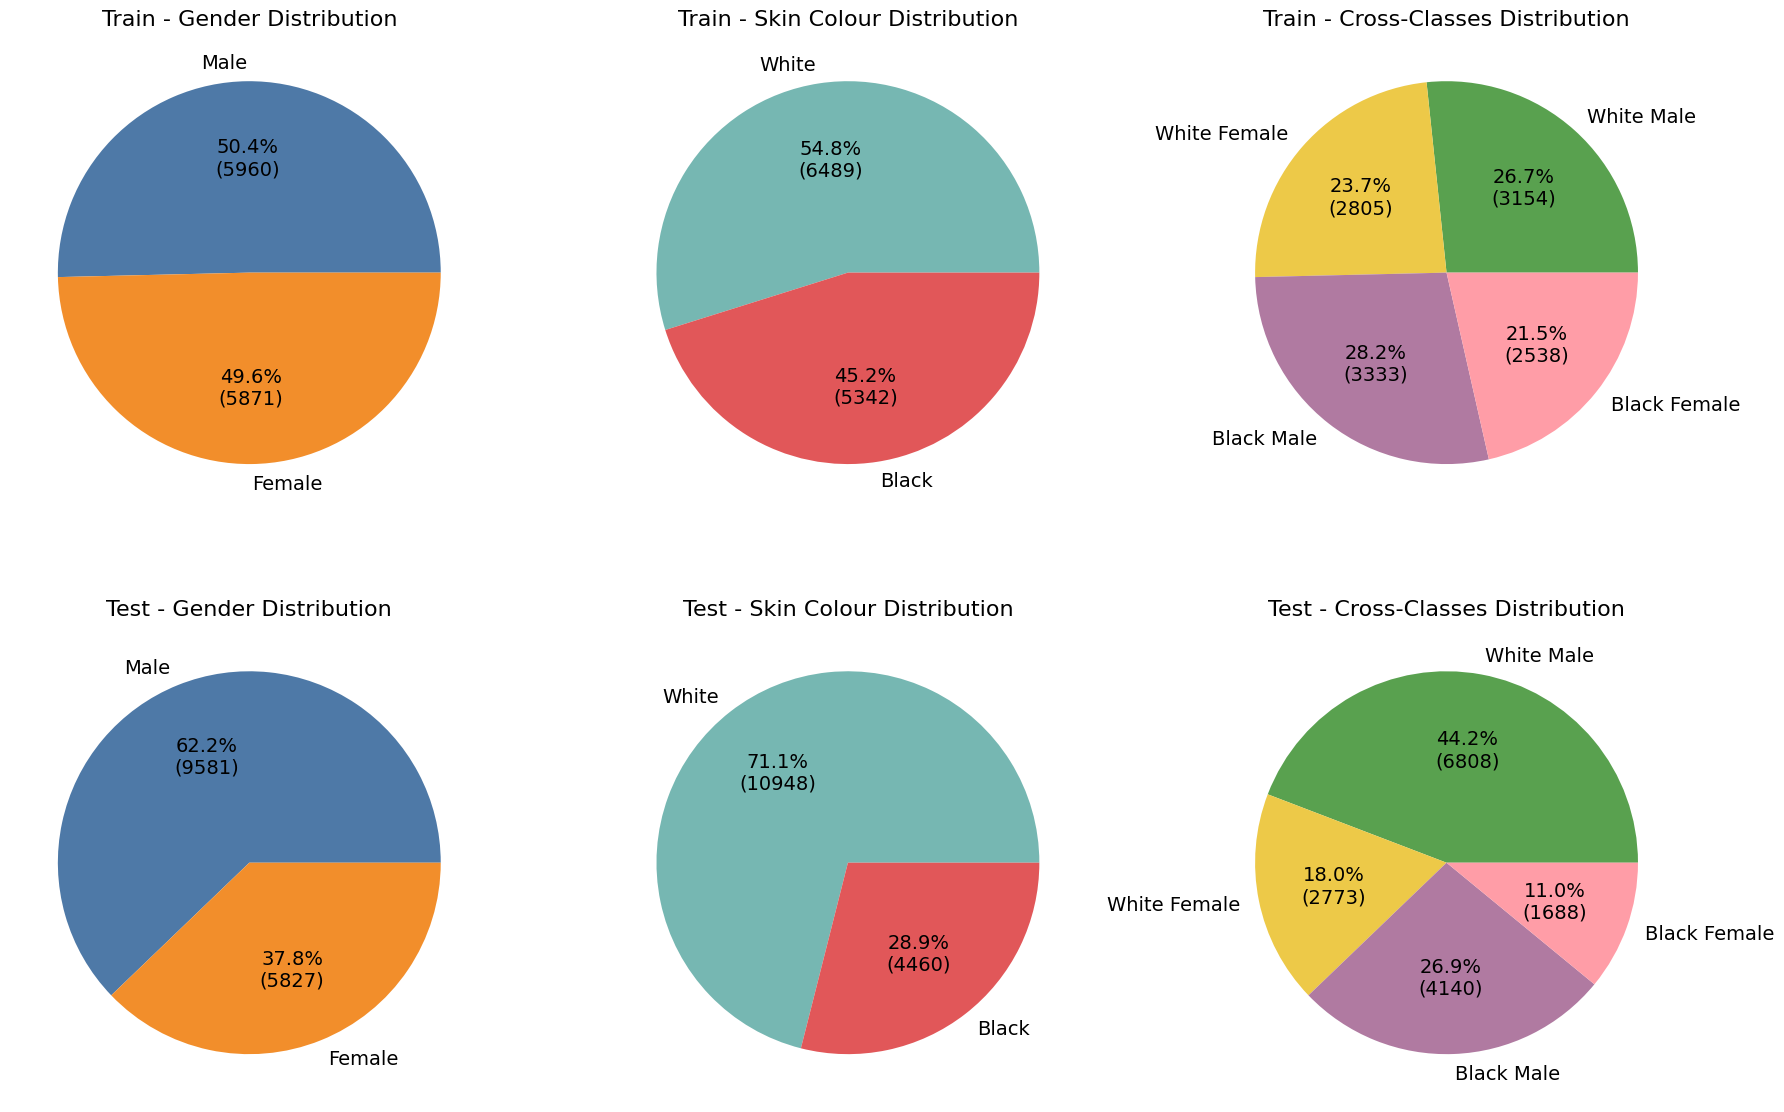

In [16]:


# Assuming you already have DataFrames 'train_df' and 'test_df'
# Prepare the counts for GENDER and SKIN_COLOUR in both train_df and test_df
train_gender_counts = train_df['GENDER'].value_counts()
train_skin_colour_counts = train_df['SKIN_COLOUR'].value_counts()
train_cross_classes = train_df.groupby(['GENDER', 'SKIN_COLOUR']).size()

test_gender_counts = test_df['GENDER'].value_counts()
test_skin_colour_counts = test_df['SKIN_COLOUR'].value_counts()
test_cross_classes = test_df.groupby(['GENDER', 'SKIN_COLOUR']).size()

# Labels for the cross-classes
labels = ['White Male', 'White Female', 'Black Male', 'Black Female']

# Function to display percentage and count on the pie chart
def func(pct, allvalues):
    absolute = int(pct/100.*sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Create a figure with six subplots (2 rows, 3 columns)
fig = plt.figure(figsize=(18, 12))

# First row (train_df)

# First subplot for GENDER in train_df
plt.subplot(2, 3, 1)
plt.pie(train_gender_counts, labels=['Male', 'Female'], autopct=lambda pct: func(pct, train_gender_counts), colors=['#4e79a7', '#f28e2b'], textprops={'fontsize': 14})
plt.title('Train - Gender Distribution', fontsize=16)

# Second subplot for SKIN_COLOUR in train_df
plt.subplot(2, 3, 2)
plt.pie(train_skin_colour_counts, labels=['White', 'Black'], autopct=lambda pct: func(pct, train_skin_colour_counts), colors=['#76b7b2', '#e15759'], textprops={'fontsize': 14})
plt.title('Train - Skin Colour Distribution', fontsize=16)

# Third subplot for Cross-Classes in train_df
plt.subplot(2, 3, 3)
plt.pie(train_cross_classes, labels=labels, autopct=lambda pct: func(pct, train_cross_classes), colors=['#59a14f', '#edc948', '#b07aa1', '#ff9da7'], textprops={'fontsize': 14})
plt.title('Train - Cross-Classes Distribution', fontsize=16)

# Second row (test_df)

# Fourth subplot for GENDER in test_df
plt.subplot(2, 3, 4)
plt.pie(test_gender_counts, labels=['Male', 'Female'], autopct=lambda pct: func(pct, test_gender_counts), colors=['#4e79a7', '#f28e2b'], textprops={'fontsize': 14})
plt.title('Test - Gender Distribution', fontsize=16)

# Fifth subplot for SKIN_COLOUR in test_df
plt.subplot(2, 3, 5)
plt.pie(test_skin_colour_counts, labels=['White', 'Black'], autopct=lambda pct: func(pct, test_skin_colour_counts), colors=['#76b7b2', '#e15759'], textprops={'fontsize': 14})
plt.title('Test - Skin Colour Distribution', fontsize=16)

# Sixth subplot for Cross-Classes in test_df
plt.subplot(2, 3, 6)
plt.pie(test_cross_classes, labels=labels, autopct=lambda pct: func(pct, test_cross_classes), colors=['#59a14f', '#edc948', '#b07aa1', '#ff9da7'], textprops={'fontsize': 14})
plt.title('Test - Cross-Classes Distribution', fontsize=16)

# Adjust layout
plt.tight_layout()

# Save the figure to a file
#plt.savefig('images/FFR_initial_distribution.png', dpi=300)

# Optionally, display the figure
plt.show()


#### BALANCED

In [12]:
train_df=df=pd.read_csv("/media/data/public/facenet/FaceRecognition/balanced_to_train.csv", index_col= 'Unnamed: 0')
train_df.sort_values("SUBJECT_ID")
train_df.sort_values("TEMPLATE_ID")

test_df =pd.read_csv("/media/data/public/facenet/FaceRecognition/balanced_to_test.csv", index_col= 'Unnamed: 0')
test_df.sort_values("SUBJECT_ID")
test_df.sort_values("TEMPLATE_ID")

train_df

,Unnamed: 0.1,TEMPLATE_ID,SUBJECT_ID,AGE,SKIN_COLOUR,GENDER,HEAD_POSE,SOURCE,GLASSES,BOUNDING_BOX_SIZE,PATH
Unnamed: 0,,,,,,,,,,,
0,0,91763,5,2,0,0,1,1,0,0,/media/data/public/facenet/datasets/FFR/test/d...
1,1,77952,5,2,0,0,0,1,0,1,/media/data/public/facenet/datasets/FFR/test/d...
2,2,66772,5,2,0,0,0,1,0,1,/media/data/public/facenet/datasets/FFR/test/d...
3,3,10882,5,2,0,0,0,1,0,1,/media/data/public/facenet/datasets/FFR/test/d...
4,4,82276,5,2,0,0,1,0,0,1,/media/data/public/facenet/datasets/FFR/test/d...
...,...,...,...,...,...,...,...,...,...,...,...
35583,29872,52290,32619,0,1,1,0,0,0,1,/media/data/public/facenet/datasets/FFR/test/d...
35584,29873,107738,32619,0,1,1,0,0,0,1,/media/data/public/facenet/datasets/FFR/test/d...
35585,29874,66258,32619,0,1,1,1,0,0,1,/media/data/public/facenet/datasets/FFR/test/d...


In [42]:

grouped = train_df.groupby(['SUBJECT_ID', 'GENDER', 'SKIN_COLOUR']).agg({"TEMPLATE_ID": "count"}).reset_index()
grouped.columns = ['SUBJECT_ID', 'GENDER', 'SKIN_COLOUR', "COUNT"]

white_males = grouped.query("GENDER==0 and SKIN_COLOUR==0").sort_values("COUNT").query("COUNT>1")
white_females = grouped.query("GENDER==1 and SKIN_COLOUR==0").sort_values("COUNT").query("COUNT>1")
black_males = grouped.query("GENDER==0 and SKIN_COLOUR==1").sort_values("COUNT").query("COUNT>1")
black_females = grouped.query("GENDER==1 and SKIN_COLOUR==1").sort_values("COUNT").query("COUNT>1")

template_lists = train_df.groupby('SUBJECT_ID')['TEMPLATE_ID'].apply(list).reset_index()
template_lists.columns = ['SUBJECT_ID', 'TEMPLATE_IDS']

white_males = white_males.merge(template_lists, on='SUBJECT_ID', how='left')
white_females = white_females.merge(template_lists, on='SUBJECT_ID', how='left')
black_males = black_males.merge(template_lists, on='SUBJECT_ID', how='left')
black_females = black_females.merge(template_lists, on='SUBJECT_ID', how='left')

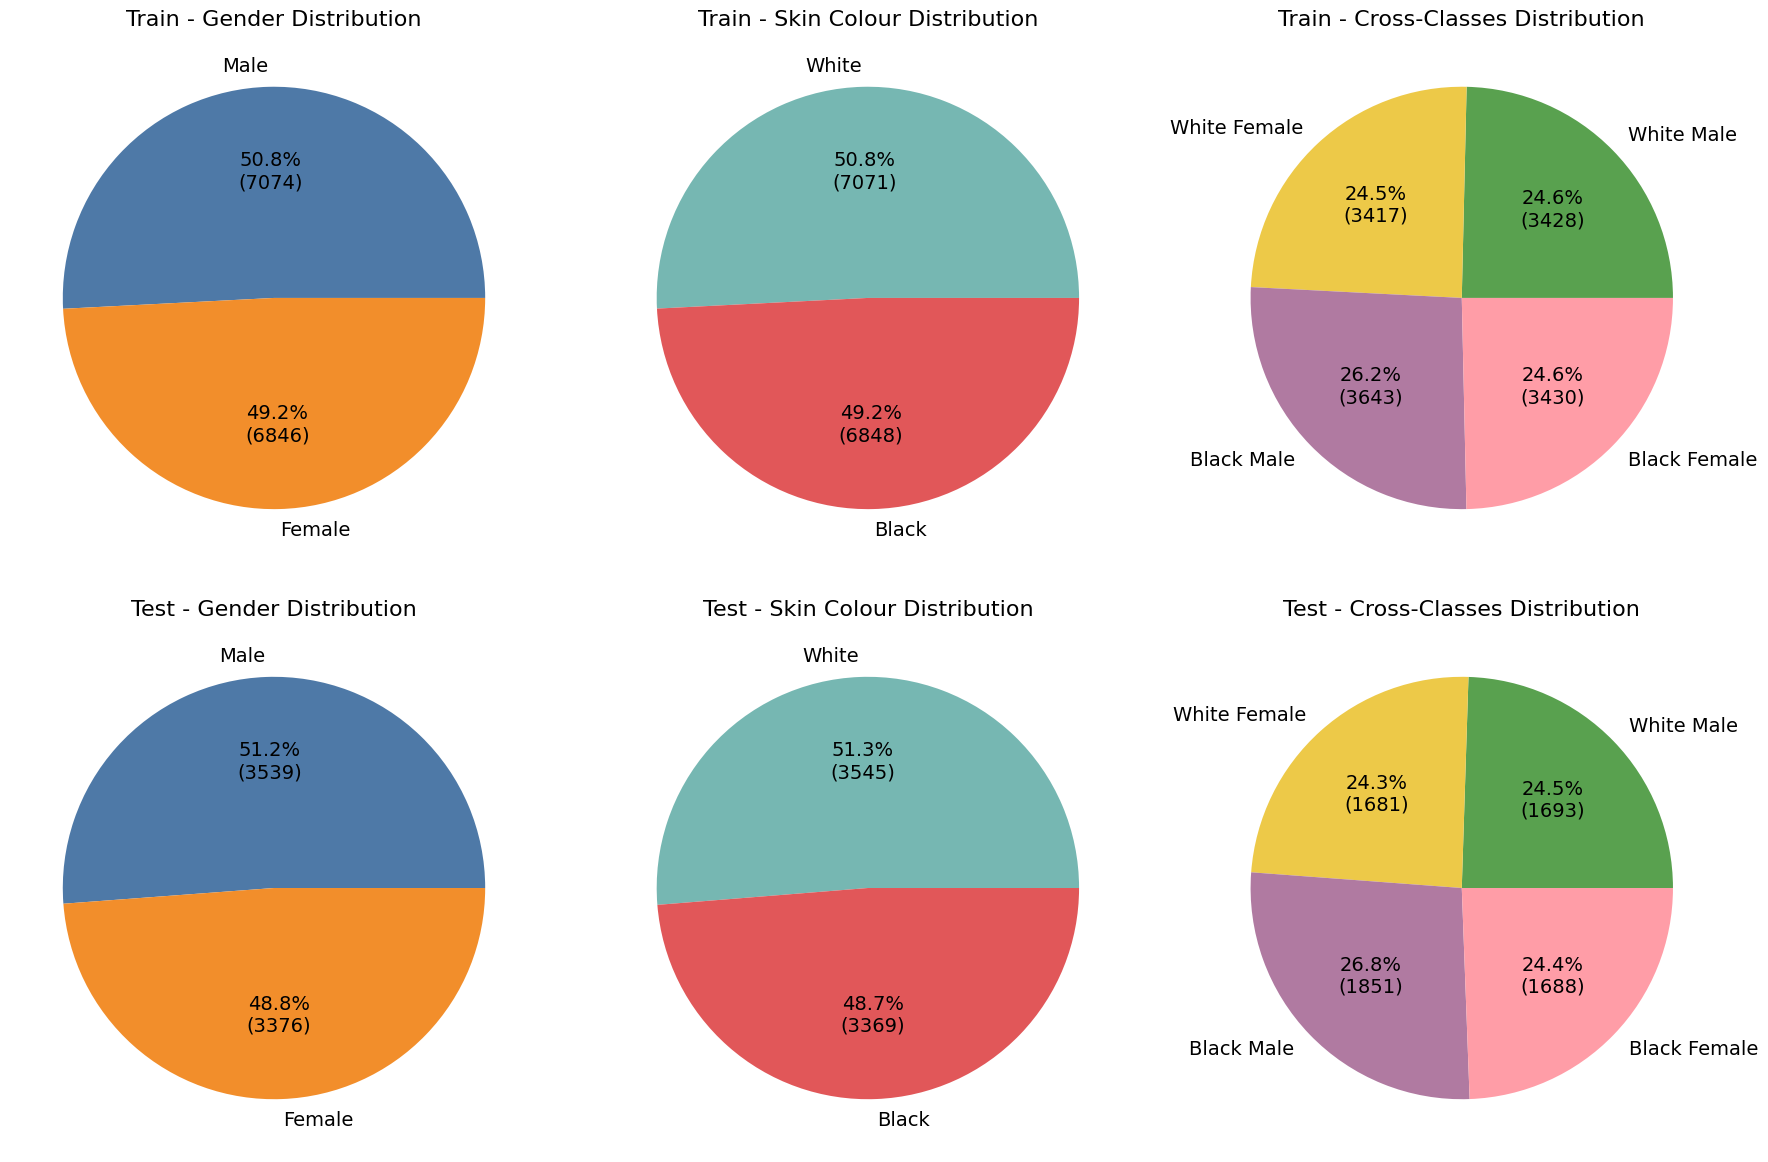

In [43]:

# Assuming you already have DataFrames 'train_df' and 'test_df'
# Prepare the counts for GENDER and SKIN_COLOUR in both train_df and test_df
train_gender_counts = train_df['GENDER'].value_counts()
train_skin_colour_counts = train_df['SKIN_COLOUR'].value_counts()
train_cross_classes = train_df.groupby(['GENDER', 'SKIN_COLOUR']).size()

test_gender_counts = test_df['GENDER'].value_counts()
test_skin_colour_counts = test_df['SKIN_COLOUR'].value_counts()
test_cross_classes = test_df.groupby(['GENDER', 'SKIN_COLOUR']).size()

# Labels for the cross-classes
labels = ['White Male', 'White Female', 'Black Male', 'Black Female']

# Function to display percentage and count on the pie chart
def func(pct, allvalues):
    absolute = int(pct/100.*sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Create a figure with six subplots (2 rows, 3 columns)
fig = plt.figure(figsize=(18, 12))

# First row (train_df)

# First subplot for GENDER in train_df
plt.subplot(2, 3, 1)
plt.pie(train_gender_counts, labels=['Male', 'Female'], autopct=lambda pct: func(pct, train_gender_counts), colors=['#4e79a7', '#f28e2b'], textprops={'fontsize': 14})
plt.title('Train - Gender Distribution', fontsize=16)

# Second subplot for SKIN_COLOUR in train_df
plt.subplot(2, 3, 2)
plt.pie(train_skin_colour_counts, labels=['White', 'Black'], autopct=lambda pct: func(pct, train_skin_colour_counts), colors=['#76b7b2', '#e15759'], textprops={'fontsize': 14})
plt.title('Train - Skin Colour Distribution', fontsize=16)

# Third subplot for Cross-Classes in train_df
plt.subplot(2, 3, 3)
plt.pie(train_cross_classes, labels=labels, autopct=lambda pct: func(pct, train_cross_classes), colors=['#59a14f', '#edc948', '#b07aa1', '#ff9da7'], textprops={'fontsize': 14})
plt.title('Train - Cross-Classes Distribution', fontsize=16)

# Second row (test_df)

# Fourth subplot for GENDER in test_df
plt.subplot(2, 3, 4)
plt.pie(test_gender_counts, labels=['Male', 'Female'], autopct=lambda pct: func(pct, test_gender_counts), colors=['#4e79a7', '#f28e2b'], textprops={'fontsize': 14})
plt.title('Test - Gender Distribution', fontsize=16)

# Fifth subplot for SKIN_COLOUR in test_df
plt.subplot(2, 3, 5)
plt.pie(test_skin_colour_counts, labels=['White', 'Black'], autopct=lambda pct: func(pct, test_skin_colour_counts), colors=['#76b7b2', '#e15759'], textprops={'fontsize': 14})
plt.title('Test - Skin Colour Distribution', fontsize=16)

# Sixth subplot for Cross-Classes in test_df
plt.subplot(2, 3, 6)
plt.pie(test_cross_classes, labels=labels, autopct=lambda pct: func(pct, test_cross_classes), colors=['#59a14f', '#edc948', '#b07aa1', '#ff9da7'], textprops={'fontsize': 14})
plt.title('Test - Cross-Classes Distribution', fontsize=16)

# Adjust layout
plt.tight_layout()

# Save the figure to a file
plt.savefig('images/FFR_balanced_distribution.png', dpi=300)

# Optionally, display the figure
plt.show()


# Part 2: Training

### Preprocessing

In [8]:

transform_train = transforms.Compose(
    [   transforms.Resize([224, 224]),
        transforms.RandomGrayscale(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (0, 0.5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

transform_val = transforms.Compose(
    [
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Training

In [6]:
def training_loop(
    name_train: str,
    num_epochs: int,
    optimizer: torch.optim,
    lr_scheduler: torch.optim.lr_scheduler,
    model: nn.Module,
    criterion: nn.Module,
    train_loader: utils.data.DataLoader,
    val_loader: utils.data.DataLoader,
    device: torch.device,
    early: EarlyStopping,
    dataset):

    losses_values_train = []
    losses_values_val = []
    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        loss_train = train(model, train_loader, device, optimizer, criterion)
        loss_val = validate(model, val_loader, device, criterion)
        time_end = timer()

        losses_values_train.append(loss_train)
        losses_values_val.append(loss_val)
        lr = optimizer.param_groups[0]["lr"]
        # Increases the internal counter
        if lr_scheduler:
            lr_scheduler.step()
        #compute the metrics every k epochs to see how the train is going.
        
        gall,targets=build_gallery(val_loader,model,device=device)
        
        recall, r_precision, mean_avg_prc=cp(gall,targets,K=1,dataset=dataset.reset_index())
        
        # write epoch results
        epoch_result_str = f"Epoch: {epoch} " f" Lr: {lr:.8f} "
        epoch_result_str += (
            f" recall= {recall:.4f} , train_loss={loss_train:.4f}, val_loss={loss_val:.4f} "
        )
        epoch_result_str += f" Time one epoch (s): {(time_end - time_start):.4f} "
        
        print(epoch_result_str)
        if 0 == epoch % 10:
            current_model_path = os.path.join(name_train, f"checkpoint_{epoch:04}.pt")
            print(f"Save current model : {current_model_path}")
            torch.save(model.state_dict(), current_model_path)
        early(recall, model, loss_train, epoch) #modified to stop when recall stops to increase
        if early.early_stop:
            break

### Train on the balanced dataset

In [10]:
name_train=''
num_epochs=30
early = EarlyStopping(
    metric_name="Recall at 3",
    patience=15,
    verbose=True,
    delta=0,
    mode='max',
    path=os.path.join(name_train, "best_val_model.pt"),
)
df=pd.read_csv("balanced_to_train.csv")
num_classes=len(df.SUBJECT_ID.unique())
print(f'Number of images: {len(df)}')
print(f'Number of classes: {num_classes}')

#split the datset
X = df.drop(columns=['SUBJECT_ID'])
y = df['SUBJECT_ID']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42,shuffle=False)
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
train_dataset=FaceDataset(train_df,transforms=transform_train)
val_dataset=FaceDataset(val_df,transforms=transform_val)
train_loader=DataLoader(train_dataset,batch_size=256,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=256,shuffle=True)


Number of images: 13920
Number of classes: 674


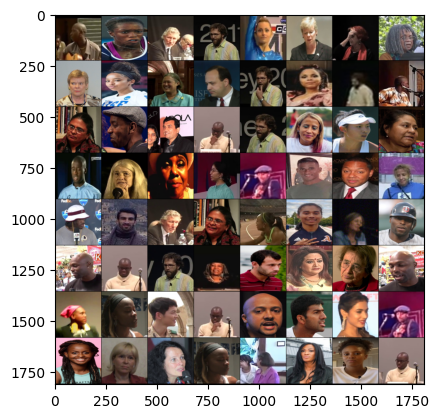

In [17]:
# get some random training images
exampleloader=DataLoader(val_dataset,batch_size=64,shuffle=True)
dataiter = iter(exampleloader)
images, labels = next(dataiter)
def imshow(img):
    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow(torchvision.utils.make_grid(images))

In [11]:

print('Training Facenet (cesia-web) with hard triplet loss on the balanced dataset')
model1=InceptionResnetV1(pretrained='casia-webface',num_classes=num_classes)     
model1=model1.to(device)
optimizer = AdamW(model1.parameters(), lr=1e-5,weight_decay=0.1)
criterion=TripletLoss()
lr_sched=lr_scheduler.StepLR(optimizer, step_size=25,gamma=0.5)

Training Facenet (cesia-web) with hard triplet loss on the balanced dataset


In [12]:
training_loop(name_train=name_train,num_epochs=num_epochs,optimizer=optimizer,lr_scheduler=lr_sched,model=model1,criterion=criterion,train_loader=train_loader,val_loader=val_loader,device=device,early=early,dataset=val_dataset.dataframe)

100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 373.01it/s]


Epoch: 1  Lr: 0.00001000  recall= 79.8851 , train_loss=0.2838, val_loss=0.3809  Time one epoch (s): 74.6061 
Recall at 3 increased (inf --> 79.885057. Saving model ... 


100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


compute metrics with K equal to 1...


2088it [00:05, 391.12it/s]


Epoch: 2  Lr: 0.00001000  recall= 81.2739 , train_loss=0.2621, val_loss=0.3708  Time one epoch (s): 74.4157 
Recall at 3 increased (79.885057 --> 81.273946. Saving model ... 


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 397.05it/s]


Epoch: 3  Lr: 0.00001000  recall= 82.0402 , train_loss=0.2487, val_loss=0.3704  Time one epoch (s): 74.6916 
Recall at 3 increased (81.273946 --> 82.040230. Saving model ... 


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 388.85it/s]


Epoch: 4  Lr: 0.00001000  recall= 82.9981 , train_loss=0.2446, val_loss=0.3747  Time one epoch (s): 74.5863 
Recall at 3 increased (82.040230 --> 82.998084. Saving model ... 


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 386.71it/s]


Epoch: 5  Lr: 0.00001000  recall= 83.4291 , train_loss=0.2306, val_loss=0.3804  Time one epoch (s): 74.7075 
Recall at 3 increased (82.998084 --> 83.429119. Saving model ... 


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 397.89it/s]


Epoch: 6  Lr: 0.00001000  recall= 83.7165 , train_loss=0.2239, val_loss=0.3684  Time one epoch (s): 74.6311 
Recall at 3 increased (83.429119 --> 83.716475. Saving model ... 


100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


compute metrics with K equal to 1...


2088it [00:05, 396.05it/s]


Epoch: 7  Lr: 0.00001000  recall= 84.0996 , train_loss=0.2144, val_loss=0.3797  Time one epoch (s): 74.4558 
Recall at 3 increased (83.716475 --> 84.099617. Saving model ... 


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 400.63it/s]


Epoch: 8  Lr: 0.00001000  recall= 84.3870 , train_loss=0.2116, val_loss=0.3777  Time one epoch (s): 74.5216 
Recall at 3 increased (84.099617 --> 84.386973. Saving model ... 


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 397.59it/s]


Epoch: 9  Lr: 0.00001000  recall= 85.0096 , train_loss=0.2025, val_loss=0.3753  Time one epoch (s): 74.6300 
Recall at 3 increased (84.386973 --> 85.009579. Saving model ... 


100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


compute metrics with K equal to 1...


2088it [00:05, 398.50it/s]


Epoch: 10  Lr: 0.00001000  recall= 84.9617 , train_loss=0.1963, val_loss=0.3684  Time one epoch (s): 74.3557 
Save current model : checkpoint_0010.pt
EarlyStopping counter: 1 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


compute metrics with K equal to 1...


2088it [00:05, 396.31it/s]


Epoch: 11  Lr: 0.00001000  recall= 84.8180 , train_loss=0.1869, val_loss=0.3539  Time one epoch (s): 74.1876 
EarlyStopping counter: 2 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 392.71it/s]


Epoch: 12  Lr: 0.00001000  recall= 84.7222 , train_loss=0.1868, val_loss=0.3654  Time one epoch (s): 74.1820 
EarlyStopping counter: 3 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


compute metrics with K equal to 1...


2088it [00:05, 399.45it/s]


Epoch: 13  Lr: 0.00001000  recall= 84.9617 , train_loss=0.1844, val_loss=0.3633  Time one epoch (s): 74.3607 
EarlyStopping counter: 4 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


compute metrics with K equal to 1...


2088it [00:05, 395.73it/s]


Epoch: 14  Lr: 0.00001000  recall= 84.7222 , train_loss=0.1789, val_loss=0.3538  Time one epoch (s): 74.1994 
EarlyStopping counter: 5 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 397.64it/s]


Epoch: 15  Lr: 0.00001000  recall= 84.9617 , train_loss=0.1734, val_loss=0.3658  Time one epoch (s): 74.3060 
EarlyStopping counter: 6 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


compute metrics with K equal to 1...


2088it [00:05, 398.97it/s]


Epoch: 16  Lr: 0.00001000  recall= 85.0575 , train_loss=0.1684, val_loss=0.3590  Time one epoch (s): 74.2299 
Recall at 3 increased (85.009579 --> 85.057471. Saving model ... 


100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


compute metrics with K equal to 1...


2088it [00:05, 398.26it/s]


Epoch: 17  Lr: 0.00001000  recall= 84.9138 , train_loss=0.1627, val_loss=0.3650  Time one epoch (s): 74.3132 
EarlyStopping counter: 1 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


compute metrics with K equal to 1...


2088it [00:05, 398.95it/s]


Epoch: 18  Lr: 0.00001000  recall= 84.9138 , train_loss=0.1597, val_loss=0.3590  Time one epoch (s): 74.0442 
EarlyStopping counter: 2 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 396.89it/s]


Epoch: 19  Lr: 0.00001000  recall= 85.1533 , train_loss=0.1559, val_loss=0.3514  Time one epoch (s): 74.8341 
Recall at 3 increased (85.057471 --> 85.153257. Saving model ... 


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 396.56it/s]


Epoch: 20  Lr: 0.00001000  recall= 85.3448 , train_loss=0.1539, val_loss=0.3497  Time one epoch (s): 74.5551 
Save current model : checkpoint_0020.pt
Recall at 3 increased (85.153257 --> 85.344828. Saving model ... 


100%|██████████| 9/9 [00:05<00:00,  1.56it/s]


compute metrics with K equal to 1...


2088it [00:05, 395.82it/s]


Epoch: 21  Lr: 0.00001000  recall= 85.7280 , train_loss=0.1494, val_loss=0.3568  Time one epoch (s): 74.8691 
Recall at 3 increased (85.344828 --> 85.727969. Saving model ... 


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 397.68it/s]


Epoch: 22  Lr: 0.00001000  recall= 85.0096 , train_loss=0.1418, val_loss=0.3595  Time one epoch (s): 74.7401 
EarlyStopping counter: 1 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


compute metrics with K equal to 1...


2088it [00:05, 398.10it/s]


Epoch: 23  Lr: 0.00001000  recall= 85.2011 , train_loss=0.1384, val_loss=0.3624  Time one epoch (s): 74.2261 
EarlyStopping counter: 2 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 394.38it/s]


Epoch: 24  Lr: 0.00001000  recall= 85.1054 , train_loss=0.1342, val_loss=0.3619  Time one epoch (s): 74.3017 
EarlyStopping counter: 3 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 397.01it/s]


Epoch: 25  Lr: 0.00001000  recall= 85.1054 , train_loss=0.1301, val_loss=0.3525  Time one epoch (s): 74.8585 
EarlyStopping counter: 4 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


compute metrics with K equal to 1...


2088it [00:05, 396.67it/s]


Epoch: 26  Lr: 0.00000500  recall= 85.2490 , train_loss=0.1278, val_loss=0.3581  Time one epoch (s): 74.6491 
EarlyStopping counter: 5 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 396.87it/s]


Epoch: 27  Lr: 0.00000500  recall= 85.2011 , train_loss=0.1263, val_loss=0.3575  Time one epoch (s): 74.7142 
EarlyStopping counter: 6 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 392.68it/s]


Epoch: 28  Lr: 0.00000500  recall= 85.1533 , train_loss=0.1258, val_loss=0.3598  Time one epoch (s): 74.7930 
EarlyStopping counter: 7 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 397.44it/s]


Epoch: 29  Lr: 0.00000500  recall= 85.4885 , train_loss=0.1220, val_loss=0.3577  Time one epoch (s): 74.8457 
EarlyStopping counter: 8 out of 15


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


compute metrics with K equal to 1...


2088it [00:05, 395.03it/s]


Epoch: 30  Lr: 0.00000500  recall= 85.2490 , train_loss=0.1223, val_loss=0.3592  Time one epoch (s): 74.6168 
Save current model : checkpoint_0030.pt
EarlyStopping counter: 9 out of 15


### Train only on black people

In [16]:
name_train='only_black'
num_epochs=30
early = EarlyStopping(
    metric_name="Recall at 3",
    patience=15,
    verbose=True,
    delta=0,
    mode='max',
    path=os.path.join(name_train, "best_val_model.pt"),
)
df=pd.read_csv("original_dataset.csv")
df=df.query('SKIN_COLOUR==1')
num_classes=len(df.SUBJECT_ID.unique())
print(f'Number of images: {len(df)}')
print(f'Number of classes: {num_classes}')

#split the datset
X = df.drop(columns=['SUBJECT_ID'])
y = df['SUBJECT_ID']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42,shuffle=False)
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
train_dataset=FaceDataset(train_df,transforms=transform_train)
val_dataset=FaceDataset(val_df,transforms=transform_val)
train_loader=DataLoader(train_dataset,batch_size=256,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=256,shuffle=True)

Number of images: 8903
Number of classes: 440


In [18]:
print('Training Facenet (cesia-web) with hard triplet loss on the only black dataset')
model2=InceptionResnetV1(pretrained='casia-webface',num_classes=num_classes)     
model2=model2.to(device)
optimizer = AdamW(model2.parameters(), lr=1e-5,weight_decay=0.1)
criterion=TripletLoss()
lr_scheduler=lr_scheduler.StepLR(optimizer, step_size=25,gamma=0.5)

Training Facenet (cesia-web) with hard triplet loss on the only black dataset


In [19]:
training_loop(name_train=name_train,num_epochs=num_epochs,optimizer=optimizer,lr_scheduler=lr_scheduler,model=model2,criterion=criterion,train_loader=train_loader,val_loader=val_loader,device=device,early=early,dataset=val_dataset.dataframe)

100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 539.88it/s]


Epoch: 1  Lr: 0.00001000  recall= 57.5599 , train_loss=0.3762, val_loss=0.3105  Time one epoch (s): 48.4091 
Recall at 3 increased (inf --> 57.559880. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 538.28it/s]


Epoch: 2  Lr: 0.00001000  recall= 60.0299 , train_loss=0.3494, val_loss=0.3050  Time one epoch (s): 48.0647 
Recall at 3 increased (57.559880 --> 60.029940. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


compute metrics with K equal to 1...


1336it [00:02, 536.01it/s]


Epoch: 3  Lr: 0.00001000  recall= 61.2275 , train_loss=0.3373, val_loss=0.3037  Time one epoch (s): 48.2124 
Recall at 3 increased (60.029940 --> 61.227545. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 538.28it/s]


Epoch: 4  Lr: 0.00001000  recall= 63.5479 , train_loss=0.3276, val_loss=0.3031  Time one epoch (s): 48.1541 
Recall at 3 increased (61.227545 --> 63.547904. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 538.35it/s]


Epoch: 5  Lr: 0.00001000  recall= 64.9701 , train_loss=0.3164, val_loss=0.2953  Time one epoch (s): 48.2814 
Recall at 3 increased (63.547904 --> 64.970060. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


compute metrics with K equal to 1...


1336it [00:02, 535.96it/s]


Epoch: 6  Lr: 0.00001000  recall= 65.5689 , train_loss=0.3087, val_loss=0.2903  Time one epoch (s): 48.3655 
Recall at 3 increased (64.970060 --> 65.568862. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


compute metrics with K equal to 1...


1336it [00:02, 536.44it/s]


Epoch: 7  Lr: 0.00001000  recall= 65.9431 , train_loss=0.3014, val_loss=0.2849  Time one epoch (s): 48.3886 
Recall at 3 increased (65.568862 --> 65.943114. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 541.48it/s]


Epoch: 8  Lr: 0.00001000  recall= 66.1677 , train_loss=0.2897, val_loss=0.3026  Time one epoch (s): 48.3736 
Recall at 3 increased (65.943114 --> 66.167665. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 543.07it/s]


Epoch: 9  Lr: 0.00001000  recall= 67.3653 , train_loss=0.2854, val_loss=0.2958  Time one epoch (s): 48.1378 
Recall at 3 increased (66.167665 --> 67.365269. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 538.22it/s]


Epoch: 10  Lr: 0.00001000  recall= 67.8144 , train_loss=0.2736, val_loss=0.2856  Time one epoch (s): 48.3749 
Save current model : only_black/checkpoint_0010.pt
Recall at 3 increased (67.365269 --> 67.814371. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 544.92it/s]


Epoch: 11  Lr: 0.00001000  recall= 67.7395 , train_loss=0.2672, val_loss=0.2887  Time one epoch (s): 48.0559 
EarlyStopping counter: 1 out of 15


100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


compute metrics with K equal to 1...


1336it [00:02, 544.89it/s]


Epoch: 12  Lr: 0.00001000  recall= 68.2635 , train_loss=0.2635, val_loss=0.2854  Time one epoch (s): 48.2490 
Recall at 3 increased (67.814371 --> 68.263473. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 537.55it/s]


Epoch: 13  Lr: 0.00001000  recall= 68.0389 , train_loss=0.2558, val_loss=0.2902  Time one epoch (s): 48.2832 
EarlyStopping counter: 1 out of 15


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 529.77it/s]


Epoch: 14  Lr: 0.00001000  recall= 68.1886 , train_loss=0.2458, val_loss=0.2900  Time one epoch (s): 48.2859 
EarlyStopping counter: 2 out of 15


100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


compute metrics with K equal to 1...


1336it [00:02, 538.55it/s]


Epoch: 15  Lr: 0.00001000  recall= 68.7874 , train_loss=0.2364, val_loss=0.2786  Time one epoch (s): 48.1932 
Recall at 3 increased (68.263473 --> 68.787425. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 539.73it/s]


Epoch: 16  Lr: 0.00001000  recall= 69.6108 , train_loss=0.2313, val_loss=0.2949  Time one epoch (s): 48.1851 
Recall at 3 increased (68.787425 --> 69.610778. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 539.79it/s]


Epoch: 17  Lr: 0.00001000  recall= 69.0868 , train_loss=0.2265, val_loss=0.2926  Time one epoch (s): 48.1961 
EarlyStopping counter: 1 out of 15


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 539.48it/s]


Epoch: 18  Lr: 0.00001000  recall= 70.5090 , train_loss=0.2227, val_loss=0.2817  Time one epoch (s): 48.2973 
Recall at 3 increased (69.610778 --> 70.508982. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 538.91it/s]


Epoch: 19  Lr: 0.00001000  recall= 70.6587 , train_loss=0.2167, val_loss=0.2828  Time one epoch (s): 48.3922 
Recall at 3 increased (70.508982 --> 70.658683. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


compute metrics with K equal to 1...


1336it [00:02, 539.32it/s]


Epoch: 20  Lr: 0.00001000  recall= 70.5090 , train_loss=0.2092, val_loss=0.2849  Time one epoch (s): 48.1954 
Save current model : only_black/checkpoint_0020.pt
EarlyStopping counter: 1 out of 15


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 537.64it/s]


Epoch: 21  Lr: 0.00001000  recall= 69.6856 , train_loss=0.2097, val_loss=0.2822  Time one epoch (s): 48.0444 
EarlyStopping counter: 2 out of 15


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 537.15it/s]


Epoch: 22  Lr: 0.00001000  recall= 69.5359 , train_loss=0.1979, val_loss=0.2855  Time one epoch (s): 48.1286 
EarlyStopping counter: 3 out of 15


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 540.58it/s]


Epoch: 23  Lr: 0.00001000  recall= 70.6587 , train_loss=0.1943, val_loss=0.2750  Time one epoch (s): 48.1929 
Recall at 3 increased (70.658683 --> 70.658683. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


compute metrics with K equal to 1...


1336it [00:02, 540.37it/s]


Epoch: 24  Lr: 0.00001000  recall= 70.8084 , train_loss=0.1895, val_loss=0.2842  Time one epoch (s): 48.2060 
Recall at 3 increased (70.658683 --> 70.808383. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 531.68it/s]


Epoch: 25  Lr: 0.00001000  recall= 70.8084 , train_loss=0.1851, val_loss=0.2915  Time one epoch (s): 48.2028 
Recall at 3 increased (70.808383 --> 70.808383. Saving model ... 


100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


compute metrics with K equal to 1...


1336it [00:02, 528.15it/s]


Epoch: 26  Lr: 0.00001000  recall= 70.2096 , train_loss=0.1796, val_loss=0.2752  Time one epoch (s): 48.1700 
EarlyStopping counter: 1 out of 15


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 539.04it/s]


Epoch: 27  Lr: 0.00001000  recall= 70.5090 , train_loss=0.1783, val_loss=0.2857  Time one epoch (s): 47.9348 
EarlyStopping counter: 2 out of 15


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 538.63it/s]


Epoch: 28  Lr: 0.00001000  recall= 70.3593 , train_loss=0.1704, val_loss=0.2824  Time one epoch (s): 48.3430 
EarlyStopping counter: 3 out of 15


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 540.27it/s]


Epoch: 29  Lr: 0.00001000  recall= 70.2096 , train_loss=0.1685, val_loss=0.2881  Time one epoch (s): 48.1855 
EarlyStopping counter: 4 out of 15


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


compute metrics with K equal to 1...


1336it [00:02, 536.75it/s]


Epoch: 30  Lr: 0.00001000  recall= 69.9850 , train_loss=0.1617, val_loss=0.2864  Time one epoch (s): 48.1980 
Save current model : only_black/checkpoint_0030.pt
EarlyStopping counter: 5 out of 15


### Train only on women

In [24]:
name_train='only_women'
num_epochs=30
early = EarlyStopping(
    metric_name="Recall at 3",
    patience=15,
    verbose=True,
    delta=0,
    mode='max',
    path=os.path.join(name_train, "best_val_model.pt"),
)
df=pd.read_csv("original_dataset.csv")
df=df.query('GENDER==1')
num_classes=len(df.SUBJECT_ID.unique())
print(f'Number of images: {len(df)}')
print(f'Number of classes: {num_classes}')

#split the datset
X = df.drop(columns=['SUBJECT_ID'])
y = df['SUBJECT_ID']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42,shuffle=False)
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
train_dataset=FaceDataset(train_df,transforms=transform_train)
val_dataset=FaceDataset(val_df,transforms=transform_val)
train_loader=DataLoader(train_dataset,batch_size=256,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=256,shuffle=True)

Number of images: 13493
Number of classes: 553


In [25]:
print('Training Facenet (cesia-web) with hard triplet loss on the only women dataset')
model3=InceptionResnetV1(pretrained='casia-webface',num_classes=num_classes)     
model3=model3.to(device)
optimizer = AdamW(model3.parameters(), lr=1e-5,weight_decay=0.1)
criterion=TripletLoss()
#lr_scheduler=lr_scheduler.StepLR(optimizer, step_size=25,gamma=0.5)

Training Facenet (cesia-web) with hard triplet loss on the only women dataset


In [26]:
training_loop(name_train=name_train,num_epochs=num_epochs,optimizer=optimizer,lr_scheduler=lr_scheduler,model=model3,criterion=criterion,train_loader=train_loader,val_loader=val_loader,device=device,early=early,dataset=val_dataset.dataframe)

100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


compute metrics with K equal to 1...


2024it [00:05, 396.68it/s]


Epoch: 1  Lr: 0.00001000  recall= 64.8715 , train_loss=0.2927, val_loss=0.3274  Time one epoch (s): 72.1040 
Recall at 3 increased (inf --> 64.871542. Saving model ... 


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:05, 403.74it/s]


Epoch: 2  Lr: 0.00001000  recall= 68.3300 , train_loss=0.2700, val_loss=0.3332  Time one epoch (s): 71.7905 
Recall at 3 increased (64.871542 --> 68.330040. Saving model ... 


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 408.32it/s]


Epoch: 3  Lr: 0.00001000  recall= 70.5040 , train_loss=0.2545, val_loss=0.3274  Time one epoch (s): 71.9963 
Recall at 3 increased (68.330040 --> 70.503953. Saving model ... 


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 406.85it/s]


Epoch: 4  Lr: 0.00001000  recall= 71.5909 , train_loss=0.2452, val_loss=0.3184  Time one epoch (s): 72.0594 
Recall at 3 increased (70.503953 --> 71.590909. Saving model ... 


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 410.59it/s]


Epoch: 5  Lr: 0.00001000  recall= 72.4308 , train_loss=0.2408, val_loss=0.3148  Time one epoch (s): 71.9707 
Recall at 3 increased (71.590909 --> 72.430830. Saving model ... 


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 410.45it/s]


Epoch: 6  Lr: 0.00001000  recall= 72.3320 , train_loss=0.2345, val_loss=0.3099  Time one epoch (s): 71.8817 
EarlyStopping counter: 1 out of 15


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


compute metrics with K equal to 1...


2024it [00:05, 402.74it/s]


Epoch: 7  Lr: 0.00001000  recall= 73.3696 , train_loss=0.2247, val_loss=0.3103  Time one epoch (s): 72.0148 
Recall at 3 increased (72.430830 --> 73.369565. Saving model ... 


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 407.50it/s]


Epoch: 8  Lr: 0.00001000  recall= 74.2095 , train_loss=0.2221, val_loss=0.3086  Time one epoch (s): 72.0905 
Recall at 3 increased (73.369565 --> 74.209486. Saving model ... 


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 406.96it/s]


Epoch: 9  Lr: 0.00001000  recall= 74.1601 , train_loss=0.2143, val_loss=0.2998  Time one epoch (s): 72.0927 
EarlyStopping counter: 1 out of 15


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 406.42it/s]


Epoch: 10  Lr: 0.00001000  recall= 74.7530 , train_loss=0.2072, val_loss=0.3070  Time one epoch (s): 71.8746 
Save current model : only_women/checkpoint_0010.pt
Recall at 3 increased (74.209486 --> 74.752964. Saving model ... 


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 408.42it/s]


Epoch: 11  Lr: 0.00001000  recall= 74.7036 , train_loss=0.2003, val_loss=0.3096  Time one epoch (s): 72.0713 
EarlyStopping counter: 1 out of 15


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:05, 402.60it/s]


Epoch: 12  Lr: 0.00001000  recall= 74.9506 , train_loss=0.2018, val_loss=0.3059  Time one epoch (s): 71.7333 
Recall at 3 increased (74.752964 --> 74.950593. Saving model ... 


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:05, 403.90it/s]


Epoch: 13  Lr: 0.00001000  recall= 74.7036 , train_loss=0.1917, val_loss=0.3057  Time one epoch (s): 72.3338 
EarlyStopping counter: 1 out of 15


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 412.24it/s]


Epoch: 14  Lr: 0.00001000  recall= 75.5435 , train_loss=0.1933, val_loss=0.3039  Time one epoch (s): 71.8824 
Recall at 3 increased (74.950593 --> 75.543478. Saving model ... 


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 406.23it/s]


Epoch: 15  Lr: 0.00001000  recall= 76.0375 , train_loss=0.1868, val_loss=0.3006  Time one epoch (s): 71.7813 
Recall at 3 increased (75.543478 --> 76.037549. Saving model ... 


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


compute metrics with K equal to 1...


2024it [00:04, 405.96it/s]


Epoch: 16  Lr: 0.00001000  recall= 76.1858 , train_loss=0.1823, val_loss=0.3027  Time one epoch (s): 71.6505 
Recall at 3 increased (76.037549 --> 76.185771. Saving model ... 


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


compute metrics with K equal to 1...


2024it [00:05, 393.12it/s]


Epoch: 17  Lr: 0.00001000  recall= 76.0870 , train_loss=0.1801, val_loss=0.2923  Time one epoch (s): 72.0309 
EarlyStopping counter: 1 out of 15


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 405.97it/s]


Epoch: 18  Lr: 0.00001000  recall= 75.9387 , train_loss=0.1781, val_loss=0.2928  Time one epoch (s): 72.0109 
EarlyStopping counter: 2 out of 15


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 409.38it/s]


Epoch: 19  Lr: 0.00001000  recall= 75.7411 , train_loss=0.1720, val_loss=0.3069  Time one epoch (s): 71.6450 
EarlyStopping counter: 3 out of 15


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:05, 393.54it/s]


Epoch: 20  Lr: 0.00001000  recall= 76.1858 , train_loss=0.1655, val_loss=0.2981  Time one epoch (s): 71.7988 
Save current model : only_women/checkpoint_0020.pt
Recall at 3 increased (76.185771 --> 76.185771. Saving model ... 


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:05, 402.54it/s]


Epoch: 21  Lr: 0.00001000  recall= 76.0375 , train_loss=0.1650, val_loss=0.2986  Time one epoch (s): 71.7860 
EarlyStopping counter: 1 out of 15


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:05, 394.54it/s]


Epoch: 22  Lr: 0.00001000  recall= 76.4328 , train_loss=0.1597, val_loss=0.2989  Time one epoch (s): 71.6164 
Recall at 3 increased (76.185771 --> 76.432806. Saving model ... 


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 407.09it/s]


Epoch: 23  Lr: 0.00001000  recall= 75.9387 , train_loss=0.1563, val_loss=0.3016  Time one epoch (s): 71.6942 
EarlyStopping counter: 1 out of 15


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 408.00it/s]


Epoch: 24  Lr: 0.00001000  recall= 76.0375 , train_loss=0.1516, val_loss=0.2978  Time one epoch (s): 71.7858 
EarlyStopping counter: 2 out of 15


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 409.38it/s]


Epoch: 25  Lr: 0.00001000  recall= 76.4328 , train_loss=0.1504, val_loss=0.3050  Time one epoch (s): 71.4682 
Recall at 3 increased (76.432806 --> 76.432806. Saving model ... 


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 407.50it/s]


Epoch: 26  Lr: 0.00001000  recall= 75.8893 , train_loss=0.1478, val_loss=0.2958  Time one epoch (s): 71.8859 
EarlyStopping counter: 1 out of 15


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 406.70it/s]


Epoch: 27  Lr: 0.00001000  recall= 76.0375 , train_loss=0.1441, val_loss=0.2974  Time one epoch (s): 71.8628 
EarlyStopping counter: 2 out of 15


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


compute metrics with K equal to 1...


2024it [00:04, 405.11it/s]


Epoch: 28  Lr: 0.00001000  recall= 75.7905 , train_loss=0.1424, val_loss=0.3020  Time one epoch (s): 71.6352 
EarlyStopping counter: 3 out of 15


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 406.95it/s]


Epoch: 29  Lr: 0.00001000  recall= 75.8399 , train_loss=0.1366, val_loss=0.3024  Time one epoch (s): 71.8253 
EarlyStopping counter: 4 out of 15


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


compute metrics with K equal to 1...


2024it [00:04, 405.51it/s]


Epoch: 30  Lr: 0.00001000  recall= 75.3953 , train_loss=0.1329, val_loss=0.2994  Time one epoch (s): 71.8550 
Save current model : only_women/checkpoint_0030.pt
EarlyStopping counter: 5 out of 15


# Part 3: Test

In [5]:
#INITIALIZE THE DATASET
test_df=pd.read_csv("balanced_to_test.csv")
df_wm=test_df.query('SKIN_COLOUR==0 and GENDER==0')
df_ww=test_df.query('SKIN_COLOUR==0 and GENDER==1')
df_bm=test_df.query('SKIN_COLOUR==1 and GENDER==0')
df_bw=test_df.query('SKIN_COLOUR==1 and GENDER==1')
names=['white men','white women','black men','black women']
datasets=[]
datasets.append(FaceDataset(df_wm,transforms=transform_val))
datasets.append(FaceDataset(df_ww,transforms=transform_val))
datasets.append(FaceDataset(df_bm,transforms=transform_val))
datasets.append(FaceDataset(df_bw,transforms=transform_val))
loaders=[]
for dataset in datasets:
    loaders.append(DataLoader(dataset,batch_size=16))
dataframes=[]
for dataset in datasets:
    dataframes.append(dataset.dataframe)

### Test the pretrained model

In [9]:
args={'name_txt':'Pretrained model',   #where to save the computed metrics

    'ckpt':'hard_unfreezed/best_val_model.pt',   #where to retrieve the checkpoints (weights for the model)
    }



name=args['name_txt']

#INITIALIZE THE MODEL
    
model=InceptionResnetV1(pretrained='casia-webface').eval().to(device)
model.to(device)
print(name)

for j in range(4):
    print(f'Metrics for subset {names[j]}')
    gall,targets=build_gallery(loaders[j],model,device=device)
    gall=torch.tensor(gall)
    targets=torch.tensor(targets)
    for i in range(1,0,-1):
        recall, r_precision, mean_avg_prc=cp(gallery=gall.cpu(),targets=targets,K=i,dataset=dataframes[j].reset_index())
        print(f'Metrics for K equal to {i}')
        print(f'recall= {recall} , r_precision={r_precision}, mean_avg_prc={mean_avg_prc}')

Pretrained model
Metrics for subset white men


100%|██████████| 106/106 [00:05<00:00, 18.49it/s]


compute metrics with K equal to 1...


1694it [00:04, 356.65it/s]


Metrics for K equal to 1
recall= 88.84297520661157 , r_precision=47.21322008491537, mean_avg_prc=43.57254860070635
Metrics for subset white women


100%|██████████| 116/116 [00:06<00:00, 17.24it/s]


compute metrics with K equal to 1...


1852it [00:05, 334.95it/s]


Metrics for K equal to 1
recall= 84.28725701943844 , r_precision=47.55780829007579, mean_avg_prc=44.31889870168699
Metrics for subset black men


100%|██████████| 106/106 [00:06<00:00, 17.57it/s]


compute metrics with K equal to 1...


1682it [00:04, 358.16it/s]


Metrics for K equal to 1
recall= 84.7205707491082 , r_precision=44.90978582395958, mean_avg_prc=40.517537048021076
Metrics for subset black women


100%|██████████| 106/106 [00:06<00:00, 15.36it/s]


compute metrics with K equal to 1...


1688it [00:04, 358.08it/s]

Metrics for K equal to 1
recall= 81.39810426540285 , r_precision=45.226373124587816, mean_avg_prc=41.618774255322066


### Test the balanced train

In [17]:
args={'name_txt':'finetuned on balanced',   #where to save the computed metrics

    'ckpt':'weights/balanced/best_val_model.pt',   #where to retrieve the checkpoints (weights for the model)
    }


ckpt=args['ckpt']
name=args['name_txt']

#INITIALIZE THE MODEL
    
model=InceptionResnetV1(pretrained='casia-webface').eval().to(device)
model.load_state_dict(torch.load(ckpt))
model.to(device)
print(name)

for j in range(4):
    print(f'Metrics for subset {names[j]}')
    gall,targets=build_gallery(loaders[j],model,device=device)
    gall=torch.tensor(gall)
    targets=torch.tensor(targets)
    for i in range(1,0,-1):
        recall, r_precision, mean_avg_prc=cp(gallery=gall.cpu(),targets=targets,K=i,dataset=dataframes[j].reset_index())
        print(f'Metrics for K equal to {i}')
        print(f'recall= {recall} , r_precision={r_precision}, mean_avg_prc={mean_avg_prc}')

finetuned on balanced
Metrics for subset white men


100%|██████████| 106/106 [00:05<00:00, 18.21it/s]


compute metrics with K equal to 1...


1694it [00:04, 349.58it/s]


Metrics for K equal to 1
recall= 90.49586776859503 , r_precision=51.782858898470074, mean_avg_prc=48.143209962382734
Metrics for subset white women


100%|██████████| 116/116 [00:06<00:00, 17.76it/s]


compute metrics with K equal to 1...


1852it [00:05, 338.93it/s]


Metrics for K equal to 1
recall= 87.09503239740822 , r_precision=51.719714659431936, mean_avg_prc=47.89947838499165
Metrics for subset black men


100%|██████████| 106/106 [00:06<00:00, 17.48it/s]


compute metrics with K equal to 1...


1682it [00:04, 355.94it/s]


Metrics for K equal to 1
recall= 85.96908442330559 , r_precision=50.238829105724555, mean_avg_prc=45.99865805772968
Metrics for subset black women


100%|██████████| 106/106 [00:06<00:00, 16.16it/s]


compute metrics with K equal to 1...


1688it [00:04, 352.34it/s]

Metrics for K equal to 1
recall= 84.47867298578198 , r_precision=51.181431738332314, mean_avg_prc=46.79810778336328


### Test the only black train

In [14]:
args={'name_txt':'finetuned only on black',   #where to save the computed metrics

    'ckpt':'weights/only_black/best_val_model.pt',   #where to retrieve the checkpoints (weights for the model)
    }


ckpt=args['ckpt']
name=args['name_txt']

#INITIALIZE THE MODEL
    
model=InceptionResnetV1(pretrained='casia-webface').eval().to(device)
model.load_state_dict(torch.load(ckpt))
model.to(device)
print(name)

for j in range(4):
    print(f'Metrics for subset {names[j]}')
    gall,targets=build_gallery(loaders[j],model,device=device)
    gall=torch.tensor(gall)
    targets=torch.tensor(targets)
    for i in range(1,0,-1):
        recall, r_precision, mean_avg_prc=cp(gallery=gall.cpu(),targets=targets,K=i,dataset=dataframes[j].reset_index())
        print(f'Metrics for K equal to {i}')
        print(f'recall= {recall} , r_precision={r_precision}, mean_avg_prc={mean_avg_prc}')

finetuned only on black
Metrics for subset white men


100%|██████████| 106/106 [00:05<00:00, 18.33it/s]


compute metrics with K equal to 1...


1694it [00:04, 355.70it/s]


Metrics for K equal to 1
recall= 90.02361275088548 , r_precision=49.17562809785834, mean_avg_prc=45.46570699976811
Metrics for subset white women


100%|██████████| 116/116 [00:06<00:00, 17.78it/s]


compute metrics with K equal to 1...


1852it [00:05, 337.26it/s]


Metrics for K equal to 1
recall= 86.60907127429806 , r_precision=49.76556077092756, mean_avg_prc=46.02082896751729
Metrics for subset black men


100%|██████████| 106/106 [00:06<00:00, 17.01it/s]


compute metrics with K equal to 1...


1682it [00:04, 355.93it/s]


Metrics for K equal to 1
recall= 85.73127229488703 , r_precision=47.90995538078412, mean_avg_prc=43.51720824812686
Metrics for subset black women


100%|██████████| 106/106 [00:06<00:00, 16.06it/s]


compute metrics with K equal to 1...


1688it [00:04, 358.49it/s]

Metrics for K equal to 1
recall= 83.7085308056872 , r_precision=49.57873407932919, mean_avg_prc=45.24684774372339


### Test the only women train

In [15]:
args={'name_txt':'finetuned only on women',   #where to save the computed metrics

    'ckpt':'weights/only_women/best_val_model23.pt',   #where to retrieve the checkpoints (weights for the model)
    }


ckpt=args['ckpt']
name=args['name_txt']

#INITIALIZE THE MODEL
    
model=InceptionResnetV1(pretrained='casia-webface').eval().to(device)
model.load_state_dict(torch.load(ckpt))
model.to(device)
print(name)

for j in range(4):
    print(f'Metrics for subset {names[j]}')
    gall,targets=build_gallery(loaders[j],model,device=device)
    gall=torch.tensor(gall)
    targets=torch.tensor(targets)
    for i in range(1,0,-1):
        recall, r_precision, mean_avg_prc=cp(gallery=gall.cpu(),targets=targets,K=i,dataset=dataframes[j].reset_index())
        print(f'Metrics for K equal to {i}')
        print(f'recall= {recall} , r_precision={r_precision}, mean_avg_prc={mean_avg_prc}')

finetuned only on women
Metrics for subset white men


100%|██████████| 106/106 [00:05<00:00, 18.29it/s]


compute metrics with K equal to 1...


1694it [00:04, 357.10it/s]


Metrics for K equal to 1
recall= 89.96458087367178 , r_precision=50.458914532096635, mean_avg_prc=46.943488314163524
Metrics for subset white women


100%|██████████| 116/116 [00:06<00:00, 17.16it/s]


compute metrics with K equal to 1...


1852it [00:05, 336.96it/s]


Metrics for K equal to 1
recall= 87.3110151187905 , r_precision=51.52975617071272, mean_avg_prc=47.87189655012482
Metrics for subset black men


100%|██████████| 106/106 [00:06<00:00, 17.01it/s]


compute metrics with K equal to 1...


1682it [00:04, 359.42it/s]


Metrics for K equal to 1
recall= 85.25564803804994 , r_precision=45.927954605004004, mean_avg_prc=41.37993701021243
Metrics for subset black women


100%|██████████| 106/106 [00:06<00:00, 15.90it/s]


compute metrics with K equal to 1...


1688it [00:04, 348.06it/s]

Metrics for K equal to 1
recall= 85.1303317535545 , r_precision=50.619877425150314, mean_avg_prc=46.55391022799736
